Module loading - not all of these are nessecarily used in this notebook, but instead might have been used in a previous version of this code.

In [62]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.cm as cm
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.ndimage as ndimage
import scipy.stats as stats
import pandas
import glob

states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='50m',facecolor='none')
cline50m = cfeature.NaturalEarthFeature(category='physical',name='coastline',scale='50m',facecolor='none')

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

The following cell cycles over the ACORN-SAT data csv files (stored in ../data/acorn_sat/) and creates an array of delta-T (daily maximum temperature changes).

In [2]:
latlon=pandas.read_csv('../data/acorn_sat/acorn_sat_v2.1.0_daily_tmax/acorn_sat_v2.1.0_stations.csv',usecols=[0,2,3]).to_xarray().swap_dims({"index": "stn_num"})
ids=[]
names=[]
q=0
first=True
for n in glob.glob('../data/acorn_sat/acorn_sat_v2.1.0_daily_tmax/tmax.*.daily.csv'):
    site_name=pandas.read_csv(n,usecols=[3])[0:1]['site name'][0]
    station_id=pandas.read_csv(n,usecols=[2])[0:1]['site number'][0]
    lat=latlon['lat'].loc[station_id]
    if lat>-23.44:
        continue
    else:
        print(q,site_name)
        import_xr=pandas.read_csv(n,usecols=[0,1],parse_dates=['date'],dayfirst=True)[1:].to_xarray()
        tx_station=import_xr.swap_dims({"index": "date"})['maximum temperature (degC)']
        tx_station_diff=tx_station.diff(dim='date',label='lower').drop_vars('index')
        cluster_param=tx_station_diff.resample(date='M').min()
        ids.append(station_id)
        names.append(site_name)
        q+=1
        if first:
            diff_table=tx_station_diff
            clust_table=cluster_param
            first=False
        else:
            diff_table=xr.concat([diff_table,tx_station_diff],dim='station')
            clust_table=xr.concat([clust_table,cluster_param],dim='station')
diff_table=diff_table.assign_coords(station=np.arange(0,87,1))
ids=np.array(ids).astype(int)

0 CARNARVON AIRPORT
1 MEEKATHARRA AIRPORT
2 MORAWA AIRPORT
3 DALWALLINU
4 GERALDTON AIRPORT
5 PERTH AIRPORT
6 CAPE LEEUWIN
7 BRIDGETOWN
8 ESPERANCE
9 ALBANY AIRPORT
10 MERREDIN
11 CUNDERDIN AIRFIELD
12 KATANNING
13 WANDERING
14 EUCLA
15 FORREST
16 KALGOORLIE-BOULDER AIRPORT
17 GILES METEOROLOGICAL OFFICE
18 ALICE SPRINGS AIRPORT
19 WOOMERA AERODROME
20 TARCOOLA AERO
21 OODNADATTA AIRPORT
22 MARREE AERO
23 CEDUNA AMO
24 KYANCUTTA
25 PORT LINCOLN AWS
26 RAYVILLE PARK
27 CAPE BORDA
28 KENT TOWN
29 NURIOOTPA PIRSA
30 MOUNT GAMBIER AERO
31 ROBE
32 BARCALDINE POST OFFICE
33 LONGREACH AERO
34 BIRDSVILLE AIRPORT
35 GAYNDAH AIRPORT
36 BUNDABERG AERO
37 AMBERLEY AMO
38 CAPE MORETON LIGHTHOUSE
39 BRISBANE AERO
40 MILES CONSTANCE STREET
41 ST GEORGE AIRPORT
42 CHARLEVILLE AERO
43 THARGOMINDAH AIRPORT
44 WILCANNIA AERODROME AWS
45 TIBOOBURRA AIRPORT
46 COBAR MO
47 BOURKE AIRPORT AWS
48 WEST WYALONG AIRPORT AWS
49 WALGETT AIRPORT AWS
50 MOREE AERO
51 GUNNEDAH RESOURCE CENTRE
52 INVERELL (RAGLAN ST)


This loads the detected fronts from the files from the pyfront process. Output files should be in ../data/950_coarse_fronts/.

In [4]:
front_data=xr.open_dataarray('../data/950_coarse_fronts/cf_950_count_201512_coarse.nc')

In [32]:
all_front=xr.open_mfdataset('../data/950_coarse_fronts/cf_950_count_*').compute()
daily_front=all_front['count'].resample(time='1D').any()

As the ERA5 data is only available from 1979 onwards (at time of writing), we only keep the delta-T from 1979 onwards.

In [3]:
diff_table=diff_table.loc[:,'1979-01-01':]

In [5]:
data=diff_table.loc[:,'2015-12-20']

And finally, this generates figure 1 in the paper.

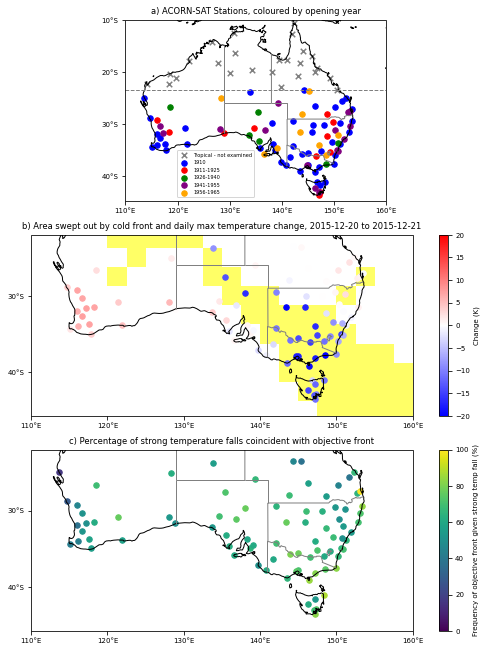

In [64]:
latlon=pandas.read_csv('../data/acorn_sat/acorn_sat_v2.1.0_daily_tmax/acorn_sat_v2.1.0_stations.csv',usecols=[0,2,3,5]).to_xarray().swap_dims({"index": "stn_num"})
ids=ids.astype(int)
s_size=30
plt.rcParams.update({'font.size': 7})
cm = 1/2.54

fig=plt.figure(figsize=(19*cm,23*cm))

ax = fig.add_subplot(3, 1, 1, projection=ccrs.PlateCarree())
norm=colors.Normalize(vmin=1910,vmax=1975)
ax.set_extent([110,160,-10,-42])
ax.add_feature(cline50m,edgecolor='k')
ax.add_feature(states_provinces,edgecolor='gray')
ax.scatter(latlon['lon'][latlon['lat']>-23.44].data,latlon['lat'][latlon['lat']>-23.44].data,marker='x',s=s_size,c='grey',transform=ccrs.PlateCarree(),label='Tropical - not examined')
ax.scatter(latlon['lon'][np.logical_and(latlon['lat']<=-23.44,latlon['year']==1910)],latlon['lat'][np.logical_and(latlon['lat']<=-23.44,latlon['year']==1910)],marker='o',s=s_size,c='blue',transform=ccrs.PlateCarree(),label='1910')
ax.scatter(latlon['lon'][np.logical_and(latlon['lat']<=-23.44,np.logical_and(latlon['year']<=1925,latlon['year']>1910))],latlon['lat'][np.logical_and(latlon['lat']<=-23.44,np.logical_and(latlon['year']<=1925,latlon['year']>1910))],marker='o',s=s_size,c='red',transform=ccrs.PlateCarree(),label='1911-1925')
ax.scatter(latlon['lon'][np.logical_and(latlon['lat']<=-23.44,np.logical_and(latlon['year']<=1940,latlon['year']>1925))],latlon['lat'][np.logical_and(latlon['lat']<=-23.44,np.logical_and(latlon['year']<=1940,latlon['year']>1925))],marker='o',s=s_size,c='green',transform=ccrs.PlateCarree(),label='1926-1940')
ax.scatter(latlon['lon'][np.logical_and(latlon['lat']<=-23.44,np.logical_and(latlon['year']<=1955,latlon['year']>1940))],latlon['lat'][np.logical_and(latlon['lat']<=-23.44,np.logical_and(latlon['year']<=1955,latlon['year']>1940))],marker='o',s=s_size,c='purple',transform=ccrs.PlateCarree(),label='1941-1955')
ax.scatter(latlon['lon'][np.logical_and(latlon['lat']<=-23.44,latlon['year']>1955)],latlon['lat'][np.logical_and(latlon['lat']<=-23.44,latlon['year']>1955)],marker='o',s=s_size,c='orange',transform=ccrs.PlateCarree(),label='1956-1965')
ax.axhline(y=-23.43637,c='gray',lw=1,ls='--')
ax.set_xticks([110,120,130,140,150,160], crs=ccrs.PlateCarree())
ax.set_yticks([-10,-20,-30,-40], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_title('a) ACORN-SAT Stations, coloured by opening year')
plt.legend(loc='lower left',bbox_to_anchor=(.19,0.01),fontsize=5)


ax = fig.add_subplot(3, 1, 2, projection=ccrs.PlateCarree())
norm=colors.Normalize(vmin=-20,vmax=20)
ax.set_extent([110,160,-22,-43])
ax.pcolormesh(front_data.longitude,front_data.latitude,(front_data.loc['2015-12-20'].any(dim='time')).where(front_data.loc['2015-12-20'].any(dim='time')),transform=ccrs.PlateCarree(),cmap='summer',vmin=0,vmax=1)
ax.add_feature(cline50m,edgecolor='k')
ax.add_feature(states_provinces,edgecolor='gray')
for m in range(len(ids)):
    sc=ax.scatter(latlon['lon'].loc[ids[m]],latlon['lat'].loc[ids[m]],marker='o',s=s_size,c=data[m],norm=norm,cmap='bwr',transform=ccrs.PlateCarree())
ax.set_xticks([110,120,130,140,150,160], crs=ccrs.PlateCarree())
ax.set_yticks([-30,-40], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_title('b) Area swept out by cold front and daily max temperature change, 2015-12-20 to 2015-12-21')
cbar = fig.colorbar(sc)
cbar.set_label("Change (K)")

ax = fig.add_subplot(3, 1, 3, projection=ccrs.PlateCarree())
norm=colors.Normalize(vmin=0,vmax=100)
ax.set_extent([110,160,-22,-43])
ax.add_feature(cline50m,edgecolor='k')
ax.add_feature(states_provinces,edgecolor='gray')
for m in range(len(ids)):
    meanfront=(daily_front.loc[diff_table.date[diff_table[m]<-10]]).mean(dim='date')
    value=meanfront.sel(latitude=[latlon['lat'].loc[ids[m]]],longitude=[latlon['lon'].loc[ids[m]]],method='nearest').data[0,0]
    sc=ax.scatter(latlon['lon'].loc[ids[m]],latlon['lat'].loc[ids[m]],marker='o',s=s_size,c=100.*value,norm=norm,transform=ccrs.PlateCarree())
ax.set_xticks([110,120,130,140,150,160], crs=ccrs.PlateCarree())
ax.set_yticks([-30,-40], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_title('c) Percentage of strong temperature falls coincident with objective front')
cbar = fig.colorbar(sc)
cbar.set_label("Frequency of objective front given strong temp fall (%)")

plt.tight_layout()
plt.savefig('fig1.pdf',bbox_inches='tight')
plt.show()